<h1 align='center'> Uncertainty in Solar Energy Generation</h1>

<h3 align='center'> Paulo Soares 2020 <br> Penn State University <br> Coded in Python 3.7.9 using Jupyter Notebook

### 1. Python Packages

In [1]:
# Required packages to run the Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import pytz
import pvlib
import glob
from ftplib import FTP
import os, sys, os.path

In [2]:
## Here we're adjusting how we want our graphics to be displayed ##
#
#Matplotlib options
from matplotlib.dates import DateFormatter
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'large'

### 2. Download data from NOAA FTP Server

<li> 5 years of data </li>
<li> User has the option to download or not the data </li>



In [3]:
#Defining the range of data to be downloaded

first_year = input("Type the first year of the data series (in YYYY): ")
first_year = int(first_year)
last_year = input("Type the last year of the data series (in YYYY): ")
last_year = int(last_year)
last_year = last_year+1
years = np.arange(first_year,last_year,1).astype(str)

#Download data from NOAA's FTP server - Or not
download = input("Type 1 to download data from NOAA server or 0 to skip: ")
download = int(download)
if download != 0:
    
    for year in years:
        ftp = FTP('aftp.cmdl.noaa.gov') # get filenames within the directory

        ftp.login()

        ftp.cwd('data/radiation/surfrad/Penn_State_PA/'+year+'/')
        filenames = ftp.nlst() 

    #print(filenames)

    for filename in filenames:
        local_filename = os.path.join('../Data/NOAA/', filename)
        file = open(local_filename, 'wb')
        ftp.retrbinary('RETR '+ filename, file.write)

        file.close()

    ftp.quit() # This is the “polite” way to close a connection
    
    #Concatenating data into a Single File
    interesting_files = glob.glob('../Data/NOAA/*.dat') 
    #print(interesting_files)
    df_list = []
    for filename in sorted(interesting_files):
        df_list.append(pd.read_csv(filename,skiprows=2,delim_whitespace=True, header=None))
    full_df = pd.concat(df_list)
    #Save raw data
    full_df.to_csv('../Data/NOAA/output-full_raw_'+year+'.csv')
    
    #Removing Original Files
    for f in interesting_files:
        os.remove(f)    
    
    print("Donwload finished. Proceed to the next cell.")
    
else:
    print("Download Skipped. Proceed to the next cell.")

Type the first year of the data series (in YYYY):  2015
Type the last year of the data series (in YYYY):  2019
Type 1 to download data from NOAA server or 0 to skip:  0


Download Skipped. Proceed to the next cell.


### 3. Create a Single Data File

In [4]:
#Concatenating the DataFrames into a single DF
data = pd.DataFrame()
headers = np.arange(0,48,1)

for year in years:
    dat = pd.read_csv('../Data/NOAA/output-full_raw_'+year+'.csv', sep=',', skiprows=0, header = 0, names = headers, index_col=0)
    data = data.append(dat)
    

In [5]:
#Saving the raw data - if desired
saved = input("Do you want to save the raw data file? (Y/N): ")

if saved == 'Y' or saved == 'y':
    data.to_csv('../Data/NOAA/output_'+years[0]+'_to_'+years[-1]+'_raw.csv')
else:
    print("No action taken. Proceed to the next cell.")

Do you want to save the raw data file? (Y/N):  n


No action taken. Proceed to the next cell.


### 4. Extracting Interesting Data
(How to interpret the NOAA files)</p>
 

In [6]:
# Loading the files
df = data
# # Renaming interesting columns
df = df.rename(index=str, columns={0: 'Year', 1:'jday', 2: 'Month',3: 'Day',4: "Hour", 5: 'Min',6:'dt', 7:'Zenith_deg', 8: 'Global_Wm2',10:'uw_solar', 12: 'Direct_Wm2',14:'Diffuse_Wm2',16:'dw_ir',18:'dw_casetemp',20:'dw_dometemp',22:'uw_ir',24:'uw_casetemp',26:'uw_dometemp',28:'uvb',30:'par',32:'netsolar',34:'netir',36:'totalnet',38:'Temp_C',40:'rh',42:'windspd',44:'winddir',46:'pressure'}) 
# #Working with only interesting data
df = df[['Year', 'Month', 'Day', 'Hour', 'Min', 'rh', 'Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2', 'Temp_C', 'pressure']]
# #Next steps set the data frame index as type datetime
df['date'] = df.Year.map(str)+'-'+df.Month.map(str)+'-'+df['Day'].map(str)+' '+df['Hour'].map(str)+':'+ df['Min'].map(str)
index = pd.DatetimeIndex(df.date)
df = df[['Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2', 'Temp_C', 'rh', 'pressure']]
df = df.set_index(index)

##### 4.1. Data Quality Assessment

In [7]:
# Removing negative and absurd values from the data set, if any
df.Global_Wm2[df.Global_Wm2 <= 0] = 0
df.Temp_C[df.Temp_C <= -40] = 0
df.Direct_Wm2[df.Direct_Wm2 <= 0] = 0
df.Diffuse_Wm2[df.Diffuse_Wm2 <= 0] = 0
df.rh[df.rh <= 0] = 30

df.Global_Wm2[df.Global_Wm2 > 1500 ]= np.nan
df.Direct_Wm2[df.Direct_Wm2 > 1500] = np.nan
df.Diffuse_Wm2[df.Diffuse_Wm2 > 1500 ]= np.nan
df.Temp_C[df.Temp_C > 40 ]= np.nan
df.rh[df.rh > 100 ]= np.nan
          
df = df.dropna()
df.describe()

,Direct_Wm2,Diffuse_Wm2,Global_Wm2,Temp_C,rh,pressure
count,2.615350e+06,2.615350e+06,2.615350e+06,2.615350e+06,2.615350e+06,2.615350e+06
mean,1.372001e+02,7.378100e+01,1.512078e+02,1.059909e+01,7.013653e+01,8.887127e+02
std,2.829508e+02,1.123726e+02,2.519684e+02,1.051644e+01,1.901991e+01,9.608934e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.520000e+01,8.500000e+00,-9.999900e+03
25%,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+00,5.670000e+01,9.692000e+02
50%,4.000000e-01,3.600000e+00,1.300000e+00,1.150000e+01,7.230000e+01,9.737000e+02
75%,1.440000e+01,1.124000e+02,2.044000e+02,1.950000e+01,8.690000e+01,9.778000e+02
max,1.058500e+03,9.268000e+02,1.405500e+03,3.460000e+01,1.000000e+02,9.971000e+02


### 5. Solar irradiance data analysis

<b>Solar irradiance </b> is the instantaneous flux of energy in <b><i>W/m$^{2}$</i></b>

<b>Solar irradiation </b> is the summation of the instantaneous flux of solar energy (irradiance) over a period of time, in <b><i>J/m$^{2}$</i></b> or in <b><i>kWh/m$^{2}$</i></b>

In [8]:
#From irradiance to energy (times 60 the energy received from the Sun during that minute) - We will change the headers later
df_mi = df[['Direct_Wm2', 'Diffuse_Wm2', 'Global_Wm2']]*60 # J/m2
df_mw = df[['Temp_C', 'rh', 'pressure']]

In [9]:
#Resampling the data - Summing the energy data, averaging the weather data - and concatenanting the files
df1 = df_mi.resample('D').sum()
df1 = df1/3.6e6  # to convert from J/m2 to kWh/m2
df2 = df_mw.resample('D').mean()

df_mon = pd.concat([df1, df2], axis=1) # Concatenating
ind = pd.DatetimeIndex(df_mon.index) #adjusting the index
df_mon = df_mon.set_index(ind)

df_month = df1.groupby(by=[df1.index.month]).mean() #average values
df_month_e = df1.groupby(pd.Grouper(freq='M')).std() #dispersion

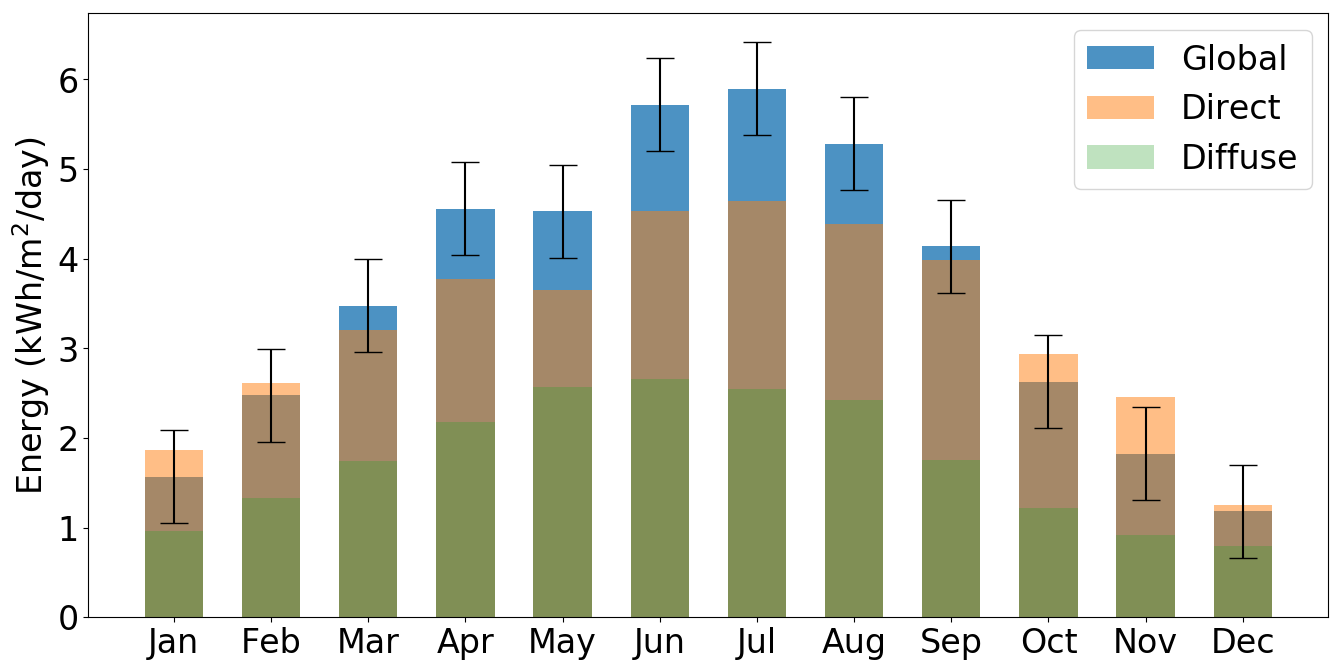

In [10]:
#Create a bar plot to better visualize previous results
N = 12 #months
labels = ['Jan', 'Feb','Mar', 'Apr','May', 'Jun','Jul', 'Aug','Sep', 'Oct','Nov', 'Dec']

#Preparing the plot
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
width = 0.6       # the width of the bars

#Plotting the bars
ax.bar(ind, df_month.Global_Wm2, width, yerr=df_month_e.Global_Wm2.std(), capsize=10, align='center', alpha=0.8)
ax.bar(ind, df_month.Direct_Wm2, width, alpha=0.5)
ax.bar(ind, df_month.Diffuse_Wm2, width, alpha=0.3)
# p4 = plt.

#Finishing...
ax.set_ylabel('Energy ' r'(kWh/m$^2$/day)')
ax.set_xticks(ind)
ax.set_xticklabels(labels)

plt.legend(['Global', 'Direct','Diffuse'])

#Saving
#plt.savefig('Results/scatter_good2.jpg')
plt.show()

Solar Irradiance components charts -  type: 1 for GHI, 2 for DNI, 3 for DHI. To skip press any other key.  1


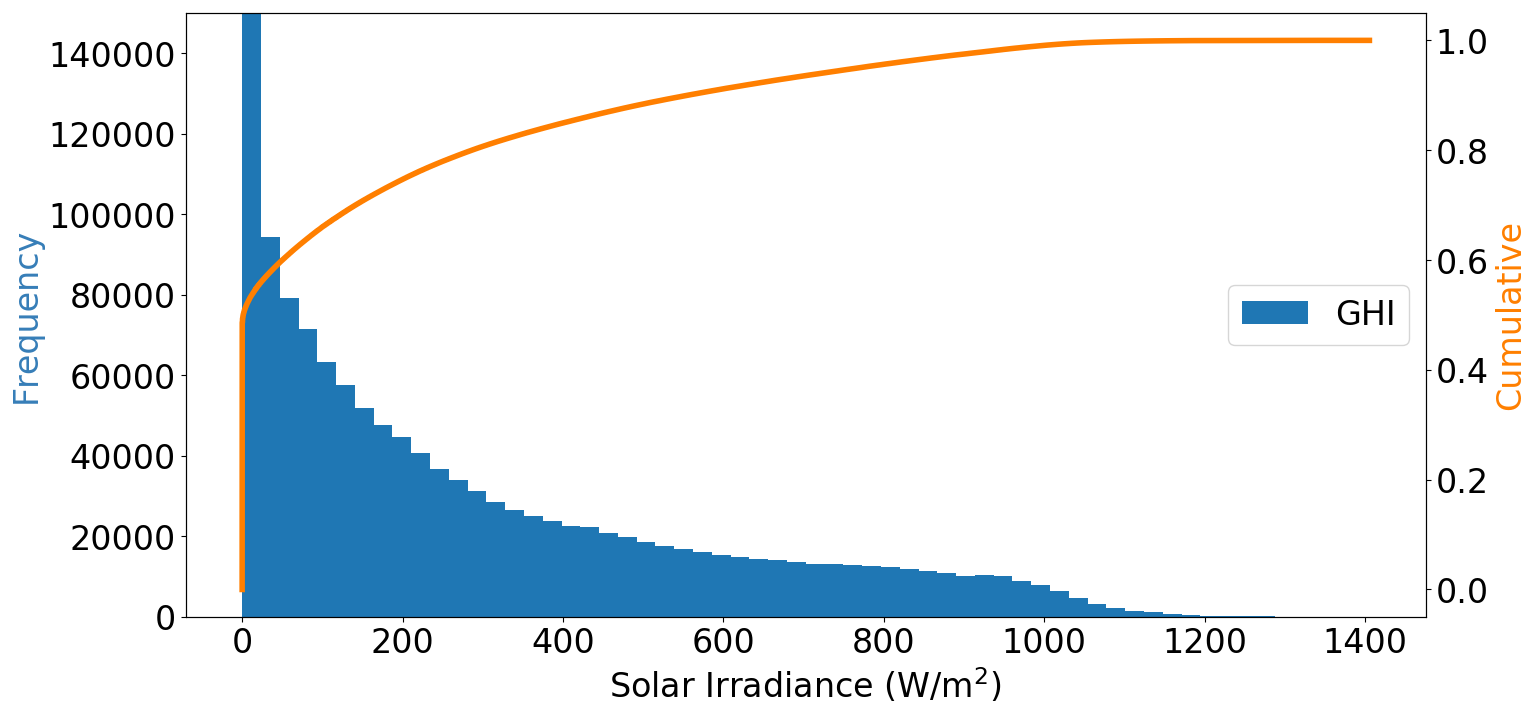

In [52]:
#Histograms and cummulative distributions - if desired
from statsmodels.distributions.empirical_distribution import ECDF
comp = input("Solar Irradiance components charts -  type: 1 for GHI, 2 for DNI, 3 for DHI. To skip press any other key. ")

if comp == '1' or comp == '2' or comp == '3':
    if comp == '1':
        key = 'Global_Wm2';leg = 'GHI'
    if comp == '2':
        key = 'Direct_Wm2';leg = 'DNI'
    if comp == '3':
        key = 'Diffuse_Wm2'; leg = 'DHI'        


    ecdf = ECDF(df[key])
    fig, ax1 = plt.subplots()

    color = '#377eb8'
    ax1.set_xlabel('Solar Irradiance (W/m$^2$)')
    ax1.set_ylabel('Frequency', color=color)
    ax1.set_ylim(0,150000)
    ax1.hist(df[key], bins=60)
    ax1.legend([leg], loc='center right')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = '#ff7f00'
    ax2.set_ylabel('Cumulative', color=color)  # we already handled the x-label with ax1
    ax2.plot(ecdf.x, ecdf.y, color=color, linewidth=4)
else:
    print('You could have seen an amazing graph. You missed your chance!')

### 6. Solar PV Generation

Using the PVLib Python package
https://pvlib-python.readthedocs.io/en/v0.8.0/index.html

#### 6.1. Preparing the Data

In [53]:
###### Loading PVLib packages 
import pvlib, pvlib.pvsystem 

import pvlib.solarposition

from pvlib.pvsystem import PVSystem

from pvlib.location import Location

from pvlib.modelchain import ModelChain, basic_chain

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [54]:
# Resampling the original data set to hourly values.
df = df.resample('H').mean()
#Calculating solar azimuth and zenith angles - This is just to test the accuracy of the PVLib solar position algorithm
lat = 40.72 # State College NOAA Surfrad Station latitude
long = -77.93 # State College NOAA Surfrad Station longitude
alt=376
new2 = pvlib.solarposition.get_solarposition(df.index, latitude=lat, longitude=long, altitude=alt , pressure=df.pressure, temperature=df.Temp_C)
df = pd.concat([df, new2[['azimuth','zenith']]], axis=1)

In [56]:
# Removing nighttime values from the df - if desired

day = input("Do you want to work with nighttime values? (Y/N): ")

if day == 'Y' or day == 'y':
    df.Zenith_deg[df.Zenith_deg > 85] = np.nan
    df = df.dropna()
    df.describe()
    print("Working with daytime values only.")
else:
    print("Working with nighttime + daytime values.")

Do you want to save the processed data file? (Y/N):  n


Working with nighttime + daytime values.


In [57]:
#Saving the hourly data set - if desired
saved = input("Do you want to save the processed data file? (Y/N): ")

if saved == 'Y' or saved == 'y':
    df.to_csv('../Data/NOAA/output_'+years[0]+'_to_'+years[-1]+'_hourly.csv')
else:
    print("No action taken. Proceed to the next cell.")

Do you want to save the processed data file? (Y/N):  n


No action taken. Proceed to the next cell.


#### 6.2. PV Generation Model

In [128]:
###### PV system specs ######

#Number of modules
N_mod = input("Enter the number of the PV modules of the system: ")
N_mod = int(N_mod)
#Number of inverters
N_inv = input("Enter the number of the inverters of the system: ")
N_inv = int(N_inv)

#Site Characteristics
lat,long = input("Enter the site latitude and longitude in decimal degrees (example: 40.72,-77.84): "  ).split(",")
lat = float(lat)
long= float(long)
alt = input("Enter the site altitude in METERS (example: 376.0): " )
alt = float(alt)
surface_tilt, surface_azimuth = input("Enter the [tilt, azimuth] angles of the PV system in degrees (example: 30, 180 ): "  ).split(",")
surface_tilt = float(surface_tilt)
surface_azimuth = float(surface_azimuth)

Enter the number of the PV modules of the system:  26
Enter the number of the inverters of the system:  1
Enter the site latitude and longitude in decimal degrees (example: 40.72,-77.84):  40.72,-77.84
Enter the site altitude in METERS (example: 376.0):  376
Enter the [tilt, azimuth] angles of the PV system in degrees (example: 30, 180 ):  30,180


In [129]:
## load some module and inverter specifications - NEEDS some refinement
# CEC modules list
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
# Selecting a module manufacturer and type
cec_module = cec_modules['SunPower_SPR_E20_327'] 

# CEC inverters list
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
# Selecting an inverter manufacturer and type
#Examples: #SMA_America__SB3800TL_US_22__208V_ / SunPower__SPR_E20_327_C_AC__208V_ / SMA_America__SB7700TL_US_22__240V_
cec_inverter = cec_inverters['SMA_America__SB7700TL_US_22__240V_']

In [130]:
# Using PVLib Model Chain To calculate the AC Power. For more information visit: https://pvlib-python.readthedocs.io/en/v0.8.0/modelchain.html

location = Location(latitude=lat, longitude=long)

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                  module_parameters=cec_module,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters, modules_per_string=N_mod/N_inv, 
                  strings_per_inverter=N_inv, altitude=alt)# Ex. 26 modules in 2 inverters:  modules_per_string=13, strings_per_inverter=2


mc = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")

weather = df[['Direct_Wm2', 'Global_Wm2', 'Diffuse_Wm2', 'Temp_C']]
weather = weather.rename(index=str, columns={'Direct_Wm2':'dni', 'Global_Wm2':'ghi', 'Diffuse_Wm2':'dhi', 'Temp_C':'temp_air'})
index = pd.DatetimeIndex(weather.index)
weather = weather.set_index(index)

print(mc)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: snlinverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses


In [131]:
# Running the model
mc.run_model(times=df.index, weather=weather);

C:\Users\Paulo\Anaconda3\lib\site-packages\pvlib\irradiance.py:862: RuntimeWarning: invalid value encountered in maximum
  sky_diffuse = np.maximum(sky_diffuse, 0)
C:\Users\Paulo\Anaconda3\lib\site-packages\pvlib\irradiance.py:494: RuntimeWarning: invalid value encountered in maximum
  poa_direct = np.maximum(dni * np.cos(np.radians(aoi)), 0)
C:\Users\Paulo\Anaconda3\lib\site-packages\pvlib\singlediode.py:418: RuntimeWarning: invalid value encountered in greater
  idx_p = 0. < Gsh
C:\Users\Paulo\Anaconda3\lib\site-packages\pvlib\tools.py:411: RuntimeWarning: invalid value encountered in greater
  df['SW_Flag'] = df['f1'] > df['f2']
C:\Users\Paulo\Anaconda3\lib\site-packages\pvlib\tools.py:418: RuntimeWarning: invalid value encountered in greater
  errflag = (abs(err) > .01).any()


#### 6.3. Visualizing the results

In [132]:
# Saving the modeled AC Power and converting from Wh to kWh
mc_ac = pd.DataFrame(list(mc.ac), columns={'AC_Power'}, index=df.index)
mc_ac.AC_Power[mc_ac.AC_Power < 0] = 0 #setting negative values to 0 
mc_ac = mc_ac/1000 # in kWh

##### 6.3.1. Monthly analysis

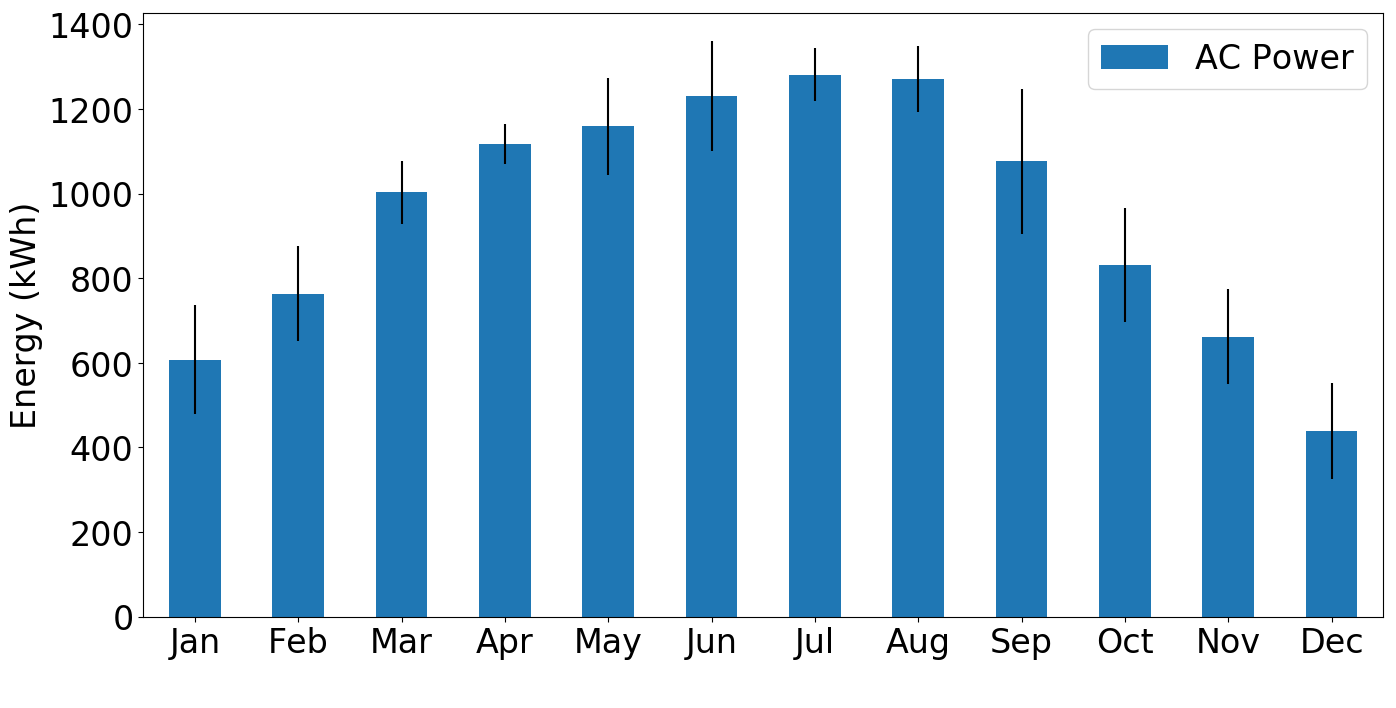

In [133]:
mc_acM = mc_ac.resample('M').sum()

# Let's viusalize the statistics
x = np.linspace(1,13,1)
fig, ax = plt.subplots()

mc_acM.groupby(mc_acM.index.month).mean().plot.bar(rot=0, ax=ax, yerr=mc_acM[['AC_Power']].groupby(mc_acM.index.month).std())

ax.set_ylabel('Energy (kWh)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax.legend(["AC Power"], loc='best')
#plt.savefig('../Results/MeanProdDif.pdf')
plt.show(block=True)

In [134]:
# Main Statistics
mc_acM.describe()

,AC_Power
count,60.000000
mean,953.154770
std,292.648027
min,311.817582
25%,744.595334
50%,1026.788667
75%,1171.071369
max,1358.618556


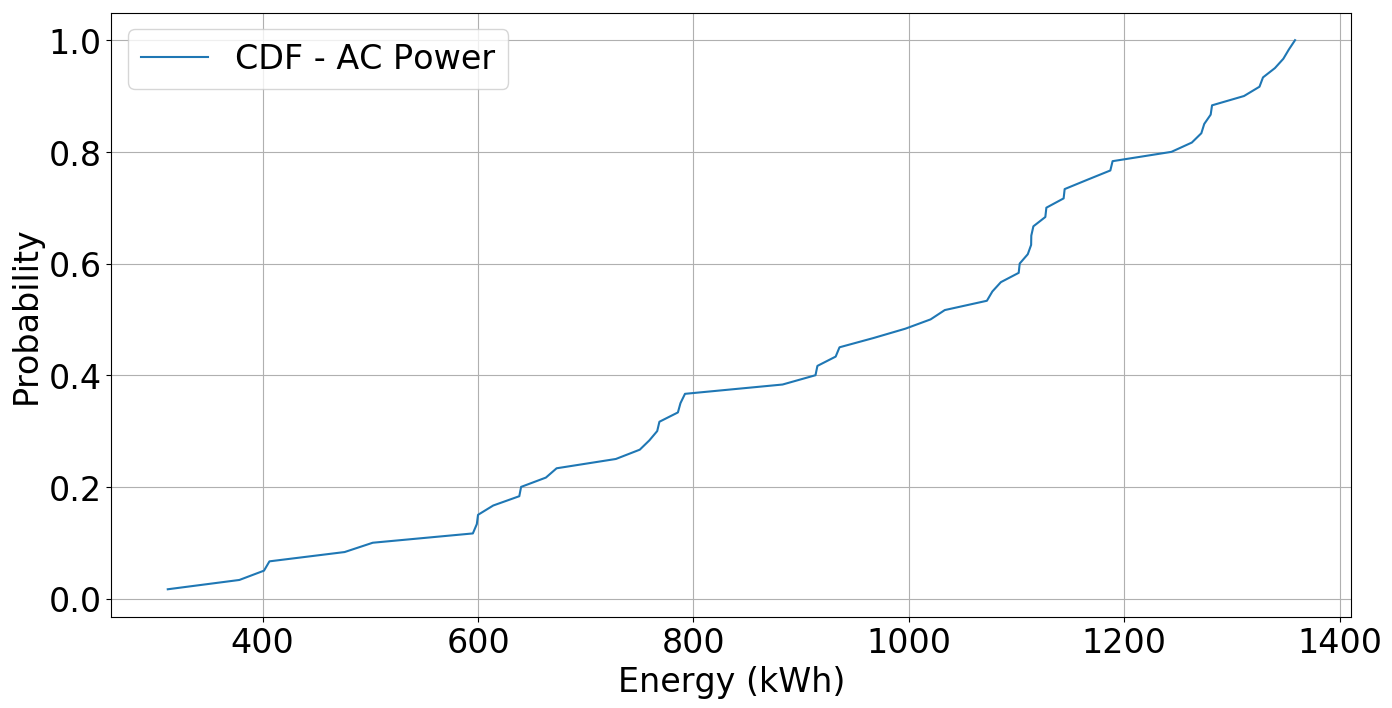

In [135]:
# Checking the probabilities of generation dropping below a certain value
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(mc_acM.AC_Power)

fig, ax = plt.subplots()

ax.plot(ecdf.x, ecdf.y)

ax.set_ylabel('Probability')
ax.set_xlabel('Energy (kWh)')
ax.grid()
ax.legend(["CDF - AC Power"], loc='best')

In [136]:
# Aiding the readability of the graph
sample = mc_acM['AC_Power']
n = len(sample)
sort = sorted(sample)
print('There is a 10% probability of having a monthly generation under', "{0:.2f}".format(sort[int(n * 0.1)])+' kWh')
print('There is a 50% probability of having a monthly generation under', "{0:.2f}".format(sort[int(n * 0.5)])+' kWh')
print('There is a 90% probability of having a monthly generation under', "{0:.2f}".format(sort[int(n * 0.9)])+' kWh')

There is a 10% probability of having a monthly generation under 595.12 kWh
There is a 50% probability of having a monthly generation under 1033.37 kWh
There is a 90% probability of having a monthly generation under 1325.60 kWh


##### 6.3.1. Yearly analysis

In [137]:
# Expected PV generation through the years - in kWh
power_year = mc_ac.resample('Y').sum() # also could have used the command: mc_ac.groupby(mc_ac.index.year).sum()
power_year

,AC_Power
date,
2015-12-31,11732.782517
2016-12-31,11933.037294
2017-12-31,11491.970485
2018-12-31,10565.268182
2019-12-31,11466.227731


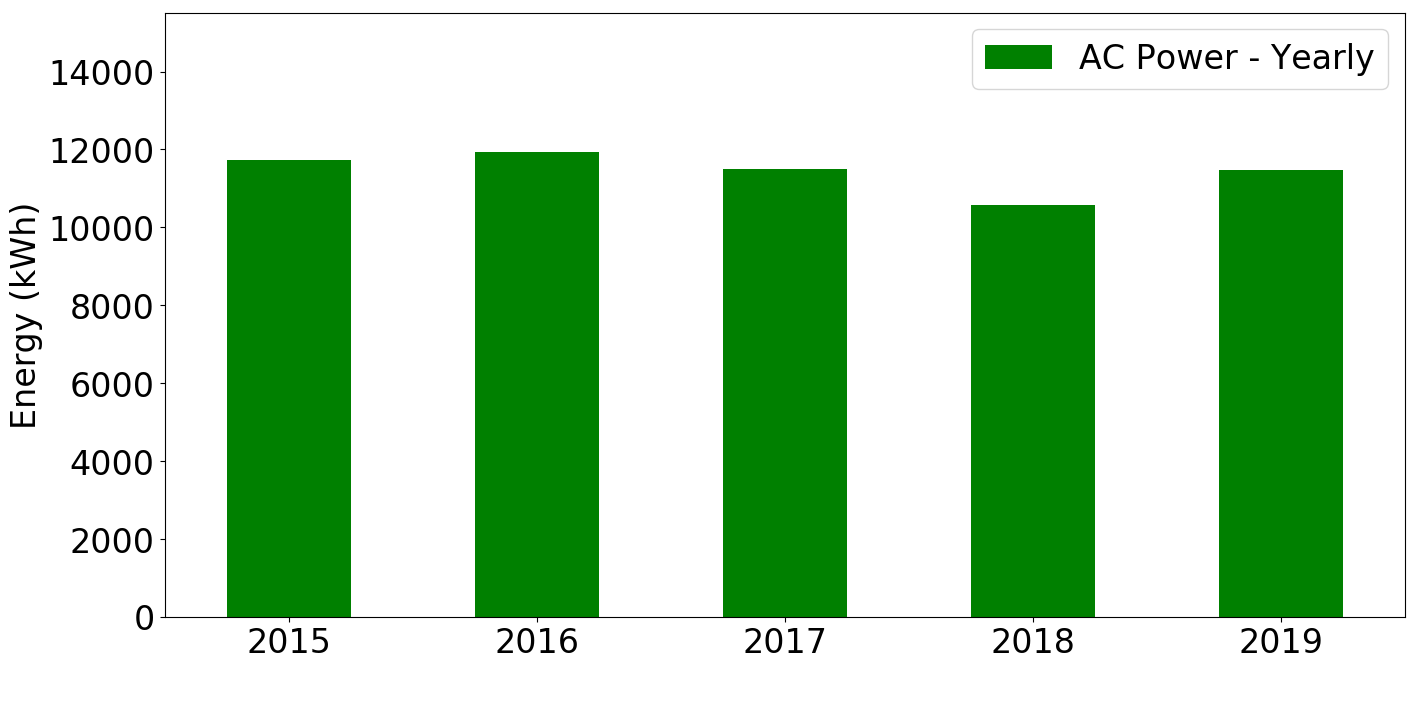

In [138]:
# Visualizing the previous dataframe
fig, ax = plt.subplots()

power_year.AC_Power.plot.bar(color='green', rot=0)

ax.set_ylabel('Energy (kWh)')
ax.set_xlabel(' ')
ax.set_ylim(0,max(power_year.AC_Power)*1.3)
ax.set_xticklabels(years)

ax.legend(["AC Power - Yearly"], loc='best')

### 7. Comparing models: Measured data X TMY data

In [147]:
# Loading the TMY file - Got lazy and used the TMY file processed by NREL System Advisor Model (SAM)
tmy_weather = pd.read_csv('../Data/TMY/StateCollege_NSRDB_TMY.csv')
# # #Working with only interesting data
tmy_weather  = tmy_weather [['dni', 'ghi', 'dhi', 'wind_speed', 'temp_air']]
index = pd.date_range(start='1/1/2015 00:00', end='12/31/2015 23:00', freq='H')
tmy_weather = tmy_weather.set_index(index)
tmy_weather.describe()

,dni,ghi,dhi,wind_speed,temp_air
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,149.898216,157.708268,73.507503,2.881963,11.498748
std,270.788737,246.282107,106.538871,2.154413,9.571939
min,0.000000,0.000000,0.000000,0.200000,-17.400000
25%,0.335000,0.000000,0.028333,1.126670,3.204582
50%,1.925835,4.456670,6.340000,2.393330,12.081700
75%,166.400250,240.531750,119.550250,4.068330,19.220425
max,1023.690000,1028.540000,589.912000,13.333300,35.293300


In [148]:
mc2 = ModelChain(system, location, aoi_model="physical", spectral_model="no_loss")
mc2.run_model(times=tmy_weather.index, weather=tmy_weather);

In [149]:
# Saving the modeled AC Power and converting from Wh to kWh
mc_ac_tmy = pd.DataFrame(list(mc2.ac), columns={'AC_Power'}, index=tmy_weather.index)
mc_ac_tmy.AC_Power[mc_ac_tmy.AC_Power < 0] = 0 #setting negative values to 0 
mc_ac_tmy = (mc_ac_tmy)/1000 # in kWh

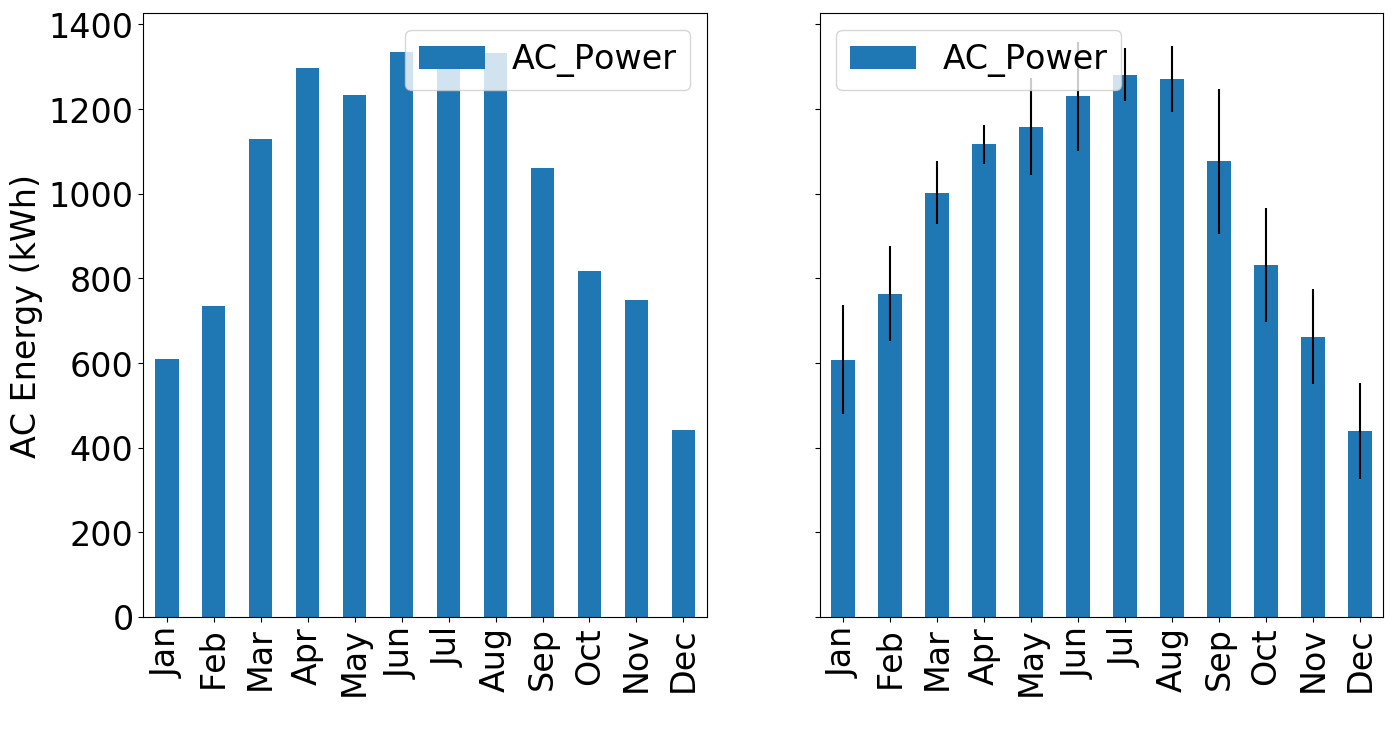

In [161]:
mct = mc_ac_tmy.resample('M').sum()

# Let's viusalize the statistics
x = np.linspace(1,13,1)

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

mct.groupby(mct.index.month).mean().plot.bar(rot=90, ax=ax, label='_nolegend_')

mc_acM.groupby(mc_acM.index.month).mean().plot.bar(rot=90, ax=ax2, yerr=mc_acM[['AC_Power']].groupby(mc_acM.index.month).std(), label='_nolegend_')

ax.set_ylabel('AC Energy (kWh)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax.legend([""], loc='best')

ax2.set_xlabel(' ')
ax2.set_xticklabels(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
ax2.legend([""], loc='best')
#plt.savefig('../Results/MeanProdDif.pdf')
plt.show(block=True)

### 8. Not Used - Saving for future reference

In [144]:
# load some module and inverter specifications - NEEDS some refinement
# cec_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

# cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# cec_module = {'STC':327.106,'PTC':302.9,'A_c':1.63,'Length':1.559,'Width':1.046,'N_s':96,'I_sc_ref':6.46,'V_oc_ref':64.9,'I_mp_ref':5.98,
# 'V_mp_ref':54.7,'alpha_sc':0.002196,'beta_oc':-0.175879,'T_NOCT':46.2,'a_ref':2.464016,'I_L_ref':6.470243,'I_o_ref':2.26523E-11,'R_s':0.417205,
# 'R_sh_ref':263.136993,'Adjust':11.129273,'gamma_r':-0.36,'Cells_in_Series':96,'Parallel_Strings':1,'Isco':6.46,'Voco':64.9,'Impo':5.98,
# 'Vmpo':54.7,'Aisc':0.002196,'Aimp':-0.00038,'C0':1.009,'C1':-0.009,'Bvoco':-0.177,'Mbvoc':0,'Bvmpo':-0.186,'Mbvmp':0,'N':1.131,'C2':0.3802,
# 'C3':-3.716,'A0':0.9597,'A1':0.03217,'A2':-0.00366,'A3':0.00006,'A4':0.0000054,'B0':1,'B1':-0.006987,'B2':0.000862,'B3':-0.000034,'B4':0.000000535,
# 'B5':-2.99E-09,'DTC':3,'FD':1,'C4':0.988,'C5':0.012,'IXO':6.08,'IXXO':4.25,'C6':1.093,'C7':-0.093}

# cec_inverter = cec_inverters['SMA_America__SB3800TL_US_22__208V_']#SMA_America__SB3800TL_US_22__208V_ ? SunPower__SPR_E20_327_C_AC__208V_

In [127]:
# Not used - ignore
# yes = pvlib.modelchain.basic_chain(times=df.index,latitude=lat, longitude=long, aoi_model="no_loss",irradiance=weather, 
#                   module_parameters=cec_module, inverter_parameters=cec_inverter, modules_per_string=13, 
#                   strings_per_inverter=2,weather=None, surface_tilt=surface_tilt, surface_azimuth=surface_azimuth, 
#                   altitude=alt, pressure=df.pressure)